In [1]:
from __future__ import annotations

from collections.abc import Iterable
from itertools import pairwise, chain
from typing import Callable, Any

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision
import tqdm.auto as tqdm
from torch import nn
import math
from torch.distributions.multivariate_normal import MultivariateNormal
from numba import cuda

%env KERAS_BACKEND=torch

import keras
from keras import layers
import keras_tuner

env: KERAS_BACKEND=torch


In [2]:
# Move to project root
from pathlib import Path
import os

if not Path("./checkpoints").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "checkpoints").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./checkpoints").is_dir()

In [3]:
from src import kernels, convolutions
from src.models import lenet_like, gangoly_cifar
from src import load_data

In [4]:
@cuda.jit("void(float32[:])")
def add_one(arr):
    x = cuda.grid(1)
    if x < arr.size:
        arr[x] += 1

In [5]:
a = torch.tensor([5, 4, 3, 2], dtype=torch.float32, device="cuda")
a

tensor([5., 4., 3., 2.], device='cuda:0')

In [6]:
add_one[1, 16](a)
a

/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


tensor([6., 5., 4., 3.], device='cuda:0')

In [7]:
test_con = 1


@cuda.jit("void(float32[:, :, :, :], float32[:, :, :, :], int64, int64, int64, int64)")
def mark_channels(arr, out, bs, cs, ys, xs):
    z, y, x = cuda.grid(3)
    b, c = divmod(z, cs)
    if x < xs and y < ys and b < bs:
        out[b, c, y, x] = arr[b, c, y, x] * c + x + y + test_con

In [8]:
a = torch.randn((256, 100, 5, 5), device="cuda")
o = torch.zeros_like(a)
o.shape

torch.Size([256, 100, 5, 5])

In [9]:
tpb = (2, 8, 8)
tot_tpb = np.prod(tpb)
print("Total TPB:", tot_tpb)
assert tot_tpb < 512, tot_tpb
nbs = (
    math.ceil(a.shape[0] * a.shape[1] / tpb[0]),
    math.ceil(a.shape[-2] / tpb[-2]),
    math.ceil(a.shape[-1] / tpb[-1]),
)
n_threads = np.prod(tpb) * np.prod(nbs)
print("NBS:", nbs)
print("N_threads", n_threads)
print("Size:", a.nelement())
print(f"Thread util: {a.nelement() / n_threads:.1%}")
assert a.nelement() <= n_threads

Total TPB: 128
NBS: (12800, 1, 1)
N_threads 1638400
Size: 640000
Thread util: 39.1%


In [10]:
def run_one():
    cuda.synchronize()
    mark_channels[nbs, tpb](a, o, *a.shape)
    cuda.synchronize()


run_one()
# %timeit run_one()

In [11]:
test_con2 = 1


@cuda.jit("void(float32[:, :, :, :], float32[:, :, :, :], int64, int64, int64, int64)")
def mark_channels_flat(arr, out, bs, cs, ys, xs):
    idx = cuda.grid(1)
    if idx >= arr.size:
        return
    idx_y, x = divmod(idx, xs)
    idx_z, y = divmod(idx_y, ys)
    b, c = divmod(idx_z, cs)
    # if x < xs and y < ys and b < bs:
    out[b, c, y, x] = arr[b, c, y, x] * c + x + y + test_con2

In [12]:
o[:] = 0
mark_channels_flat[math.ceil(a.nelement() / 32), 32](a, o, *a.shape)

In [13]:
o[:] = 0
mark_channels[nbs, tpb](a, o, *a.shape)

In [14]:
def run_one():
    cuda.synchronize()
    mark_channels_flat[math.ceil(a.nelement() / 256), 256](a, o, *a.shape)
    cuda.synchronize()


run_one()
# %timeit run_one()

In [15]:
print(o[10, 2])

tensor([[ 3.7259,  4.8477,  3.0617,  1.9581,  4.3105],
        [-0.4658,  4.6047,  3.2718,  6.0013,  6.6525],
        [ 6.5027,  1.4240,  5.9230,  6.0691,  4.9031],
        [ 2.5296,  5.7981,  6.7753,  5.6232, 10.5639],
        [ 9.9797,  4.1068,  8.7553,  6.6477,  9.3473]], device='cuda:0')


In [16]:
reduce_max = True
INF = float("inf")


@cuda.jit(
    "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
    " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X
    " float32[:, :, :, :],"  # out_img: [Batch, Channel, Img_Y, Img_X]
    " int16[:, :, :, :, :],"  # out_prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
    " int64,"  # Channels
    " int64, int64,"  # Img_Y, Img_X
    " int64, int64)",  # Kernel_Y, Kernel_X
    debug=True,
    opt=False,
)
def dilate_flat(img, kernel, out_img, out_prov, cs, i_ys, i_xs, k_ys, k_xs):
    idx = cuda.grid(1)
    if idx >= img.size:
        return
    idx_y, centre_x = divmod(idx, i_xs)
    idx_z, centre_y = divmod(idx_y, i_ys)
    b, c = divmod(idx_z, cs)

    top_y, left_x = centre_y - k_ys // 2, centre_x - k_xs // 2
    best_x = best_y = -99
    best_val = -INF if reduce_max else INF

    for k_y, i_y in enumerate(range(top_y, top_y + k_ys)):
        for k_x, i_x in enumerate(range(left_x, left_x + k_xs)):
            if i_x < 0 or i_x > i_xs or i_y < 0 or i_y > i_ys:
                continue

            if reduce_max:
                val = img[b, c, i_y, i_x] + kernel[c, k_y, k_x]
                if val > best_val:
                    best_y, best_x = i_y, i_x
                    best_val = val
            else:
                val = img[b, c, i_y, i_x] - kernel[c, k_y, k_x]
                if val < best_val:
                    best_y, best_x = i_y, i_x
                    best_val = val

    out_img[b, c, centre_y, centre_x] = best_val
    out_prov[b, c, centre_y, centre_x, 0] = best_y
    out_prov[b, c, centre_y, centre_x, 1] = best_x

/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/core/lowering.py:116: NumbaDebugInfoWarning: Could not find source for function: <function dilate_flat at 0x732d9261a5c0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))


In [17]:
mnist = load_data.mnist()

normalisation: tensor([[[33.3184]]]) tensor([[[78.5675]]])


In [18]:
test_imgs = (
    torch.asarray(mnist.x_train[:2048], device="cuda").unsqueeze(1).repeat((1, 6, 1, 1))
)
print(test_imgs.dtype)
test_imgs.shape

torch.float32


torch.Size([2048, 6, 28, 28])

In [19]:
test_kernels = -torch.asarray(
    [
        # 1: Does nothing
        [[[INF, INF, INF], [INF, 0, INF], [INF, INF, INF]]],
        # 2: Vertical max
        [[[INF, 0, INF], [INF, 0, INF], [INF, 0, INF]]],
        # 3: Horizontal max
        [[[INF, INF, INF], [0, 0, 0], [INF, INF, INF]]],
        # 4: 3x3 max
        [[[0, 0, 0], [0, 0, 0], [0, 0, 0]]],
        # 5: small quadratic max, isotropic
        [[[0.4, 0.1, 0.4], [0.1, 0, 0.1], [0.4, 0.1, 0.4]]],
        # 6: small quadratic max, wide horizontally
        [[[0.5, 0.2, 0.5], [0.05, 0, 0.05], [0.5, 0.2, 0.5]]],
    ],
    device="cuda",
).squeeze(1)
print(test_kernels.dtype)
test_kernels.shape

torch.float32


torch.Size([6, 3, 3])

In [20]:
o_i = torch.full_like(test_imgs, -700, device="cuda")
o_p = torch.full(test_imgs.shape + (2,), -699, dtype=torch.int16, device="cuda")

In [21]:
o_i[:] = -688
o_p[:] = -689
dilate_flat[math.ceil(test_imgs.nelement() / 256), 256](
    test_imgs, test_kernels, o_i, o_p, *test_imgs.shape[1:], *test_kernels.shape[1:]
)

In [22]:
def compile_tropical_conv(
    is_max: bool,
    channels: int,
    kernel_size: int,
    block_size: int = 256,
    debug: bool = False,
    calculate_prov: bool = True,
):
    cs = channels
    k_ys = k_xs = kernel_size

    @cuda.jit(
        "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X
        " float32[:, :, :, :],"  # out_img: [Batch, Channel, Img_Y, Img_X]
        f"{'int16[:, :, :, :, :],' if calculate_prov else 'int16,'}"  # out_prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
        " int64, int64)",  # Img_Y, Img_X
        debug=debug,
        opt=not debug,
    )
    def conv_cuda(img, kernel, out_img, out_prov, i_ys, i_xs):
        idx = cuda.grid(1)
        if idx >= img.size:
            return
        idx_y, centre_x = divmod(idx, i_xs)
        idx_z, centre_y = divmod(idx_y, i_ys)
        b, c = divmod(idx_z, cs)

        top_y, left_x = centre_y - k_ys // 2, centre_x - k_xs // 2
        best_x = best_y = -99
        best_val = -INF if is_max else INF

        for k_y, i_y in enumerate(range(top_y, top_y + k_ys)):
            for k_x, i_x in enumerate(range(left_x, left_x + k_xs)):
                if i_x < 0 or i_x >= i_xs or i_y < 0 or i_y >= i_ys:
                    continue

                if is_max:
                    val = img[b, c, i_y, i_x] + kernel[c, k_y, k_x]
                    if val > best_val:
                        best_val = val
                        if calculate_prov:
                            best_y, best_x = i_y, i_x
                else:
                    val = img[b, c, i_y, i_x] - kernel[c, k_y, k_x]
                    if val < best_val:
                        best_val = val
                        if calculate_prov:
                            best_y, best_x = i_y, i_x

        out_img[b, c, centre_y, centre_x] = best_val
        if calculate_prov:
            out_prov[b, c, centre_y, centre_x, 0] = best_y
            out_prov[b, c, centre_y, centre_x, 1] = best_x

    def conv(img: torch.Tensor, kernel: torch.Tensor):
        img, kernel = img.detach(), kernel.detach()
        out_img = torch.empty_like(img)
        if calculate_prov:
            out_prov = torch.empty(
                img.shape + (2,), device=img.device, dtype=torch.int16
            )
        else:
            out_prov = -1
        n_blocks = math.ceil(img.nelement() / block_size)
        conv_cuda[n_blocks, block_size](
            img, kernel, out_img, out_prov, img.shape[2], img.shape[3]
        )
        if calculate_prov:
            return out_img, out_prov
        return out_img

    return conv

In [23]:
max_op = compile_tropical_conv(is_max=True, channels=6, kernel_size=3)
min_op = compile_tropical_conv(is_max=False, channels=6, kernel_size=3)

<Figure size 640x480 with 0 Axes>

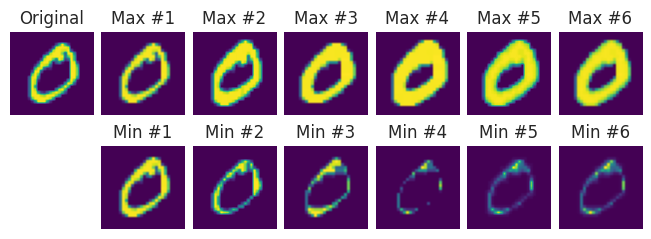

In [24]:
img_num = 1
plt.set_cmap("viridis")
_, ((ax_original, *ax_maxs), (ax_unused, *ax_mins)) = plt.subplots(
    2, 1 + 6, layout="compressed"
)
ax_original.set_axis_off()
ax_unused.set_axis_off()
ax_original.imshow(test_imgs[img_num, 0].numpy(force=True))
ax_original.set_title("Original")
max_imgs = max_op(test_imgs, test_kernels)[0]
for i, (ax, img_channel) in enumerate(
    zip(ax_maxs, max_imgs[img_num].numpy(force=True), strict=True), 1
):
    ax.set_axis_off()
    ax.imshow(img_channel)
    ax.set_title(f"Max #{i}")
min_imgs = min_op(test_imgs, test_kernels)[0]
for i, (ax, img_channel) in enumerate(
    zip(ax_mins, min_imgs[img_num].numpy(force=True), strict=True), 1
):
    ax.set_axis_off()
    ax.imshow(img_channel)
    ax.set_title(f"Min #{i}")
plt.show()

In [25]:
unfold_max = convolutions.TropicalConv2D(is_max=True)

In [26]:
def run_one():
    torch.cuda.synchronize()
    arr = unfold_max(test_imgs, test_kernels.unsqueeze(1))[0]
    del arr
    torch.cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()

In [27]:
per_img_shape = test_imgs.shape[2:]
print(per_img_shape)
np.prod(per_img_shape)

torch.Size([28, 28])


np.int64(784)

In [28]:
per_image_max_op = compile_tropical_conv(
    is_max=True, channels=6, kernel_size=3, block_size=784
)


def run_one():
    cuda.synchronize()
    arr = max_op(test_imgs, test_kernels)[0]
    del arr
    cuda.synchronize()


def run_one_per_image():
    cuda.synchronize()
    arr = per_image_max_op(test_imgs, test_kernels)[0]
    del arr
    cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()
run_one_per_image()
# %timeit run_one_per_image()
torch.cuda.empty_cache()

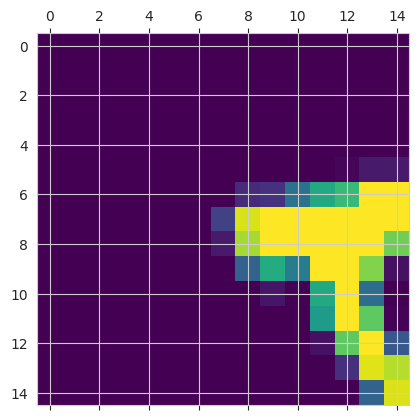

In [29]:
plt.matshow(test_imgs[0, 0, :15, :15].numpy(force=True))

In [30]:
import importlib

importlib.reload(convolutions)
from src import convolutions

Nonzero gradient in image: (array([6, 6, 7, 8]), array([8, 9, 8, 8]))


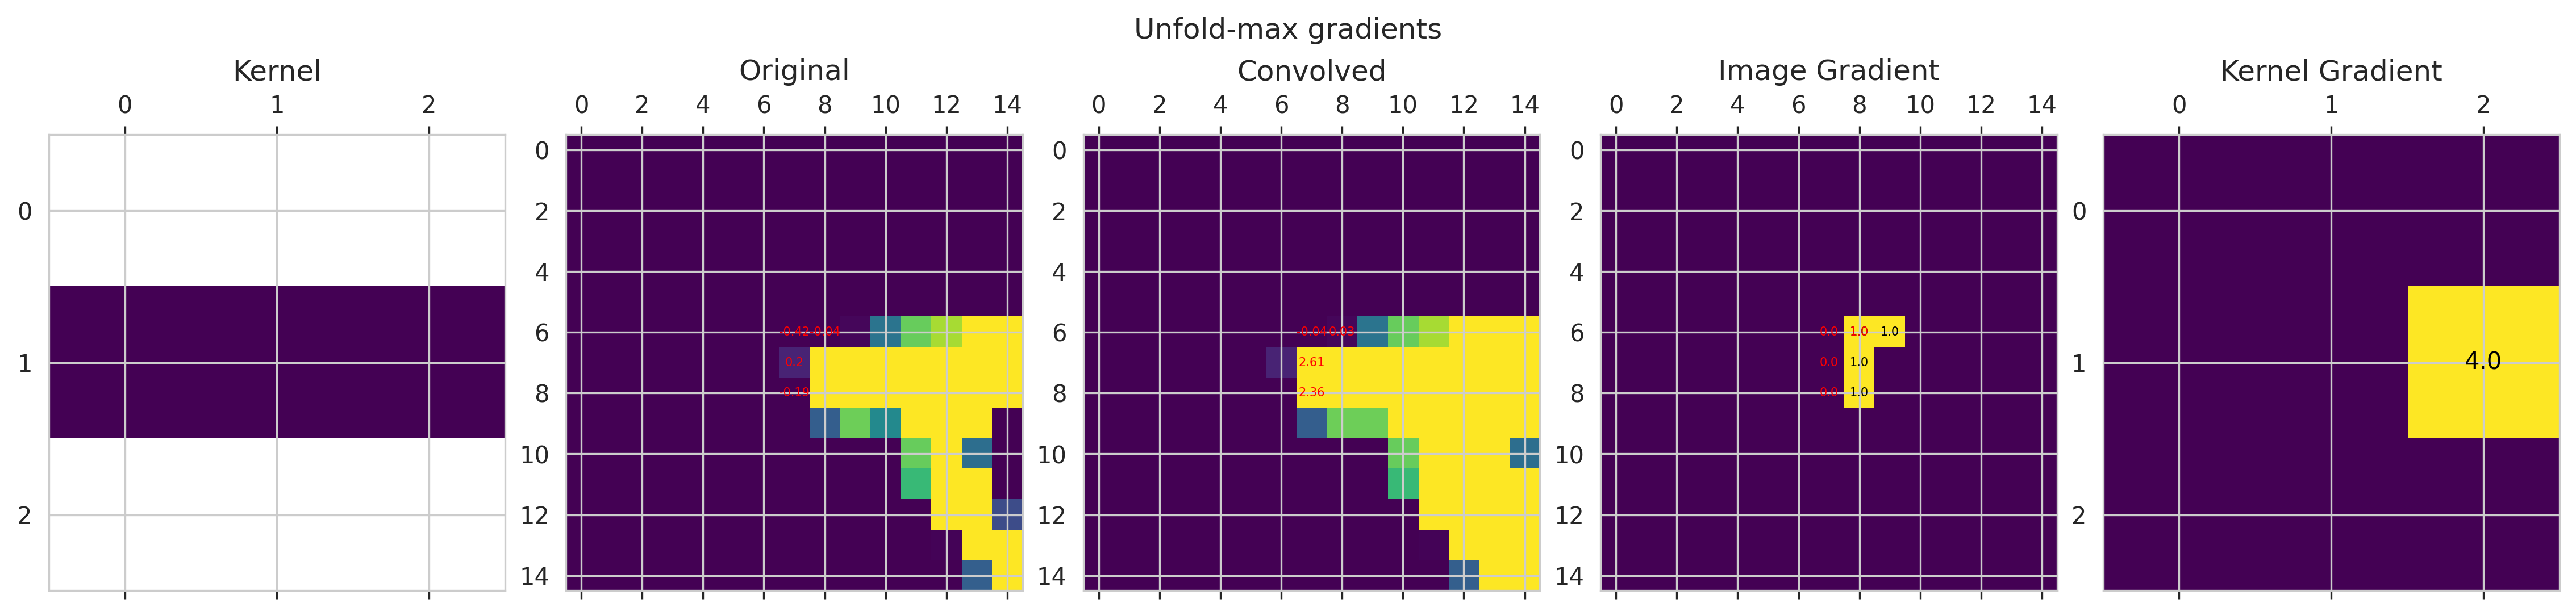

In [31]:
channel_nr = 2
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
# g_imgs[0, channel_nr, 7, 7] *= 100
g_imgs.requires_grad_(True)
g_kernels.requires_grad_(True)
g_imgs.grad = None
g_kernels.grad = None

x_slice = slice(None, 15)
y_slice = slice(None, 15)
target_xs = [7, 7, 7, 8]
target_ys = [6, 7, 8, 6]
target_x = target_y = None
res_imgs = convolutions.TropicalConv2D(is_max=True)(
    g_imgs, g_kernels.unsqueeze(1), padding=1
)
res_imgs[0, channel_nr, target_ys, target_xs].sum().backward()
_, axs = plt.subplots(ncols=5, layout="compressed", figsize=(15, 15), dpi=300)
axs[0].matshow(g_kernels[channel_nr].numpy(force=True))
axs[0].set_title("Kernel")
axs[1].matshow(
    g_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[1].set_title("Original")
axs[2].matshow(
    res_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[2].set_title("Convolved")
g_np = g_imgs.grad[0, channel_nr, y_slice, x_slice].numpy(force=True)
axs[3].matshow(g_np)
axs[3].set_title("Image Gradient")
g_np_k = g_kernels.grad[channel_nr].numpy(force=True)
axs[4].matshow(g_np_k)
axs[4].set_title("Kernel Gradient")
for g_i, g_j in zip(*g_np.nonzero()):
    axs[3].text(
        g_j, g_i, g_np[g_i, g_j], color="black", fontsize=5, ha="center", va="center"
    )
for g_i, g_j in zip(*g_np_k.nonzero()):
    axs[4].text(
        g_j, g_i, g_np_k[g_i, g_j], color="black", fontsize=10, ha="center", va="center"
    )
for ax, ax_arr in zip(axs[1:4], (g_imgs, res_imgs, g_imgs.grad)):
    for tx, ty in zip(target_xs, target_ys):
        ax.text(
            tx,
            ty,
            ax_arr[0, channel_nr, ty, tx].numpy(force=True).round(2),
            color="red",
            fontsize=5,
            ha="center",
            va="center",
        )
    # ax.scatter(target_x, target_y, marker="x", color='red')
plt.suptitle("Unfold-max gradients")
print("Nonzero gradient in image:", g_np.nonzero())

In [32]:
def compile_tropical_conv_backwards(
    is_max: bool,
    channels: int,
    kernel_size: int,
    block_size: int = 256,
    debug: bool = False,
):
    def one(v, w):
        return 1

    def minus_one(v, w):
        return -1

    cs = channels
    k_ys = k_xs = kernel_size
    if is_max:
        d_weigh_d_v = d_weigh_d_w = one
    else:
        d_weigh_d_v = one
        d_weigh_d_w = minus_one

    d_weigh_d_v = cuda.jit(d_weigh_d_v, device=True)
    d_weigh_d_w = cuda.jit(d_weigh_d_w, device=True)

    # noinspection PyArgumentList
    @cuda.jit(
        "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X]
        " float32[:, :, :, :],"  # res_tangent: [Batch, Channel, Img_Y, Img_X]
        " int16[:, :, :, :, :],"  # res_prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
        " float32[:, :, :, :],"  # out_img_grad: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # out_kernel_grad: [Channel, Kernel_Y, Kernel_X]
        " int64, int64)",  # Img_Y, Img_X
        debug=debug,
        opt=not debug,
    )
    def conv_backwards_cuda(
        img, kernel, res_tangent, res_prov, out_img_grad, out_kernel_grad, i_ys, i_xs
    ):
        idx = cuda.grid(1)
        if idx >= img.size:
            return
        idx_y, centre_x = divmod(idx, i_xs)
        idx_z, centre_y = divmod(idx_y, i_ys)
        b, c = divmod(idx_z, cs)
        tangent = res_tangent[b, c, centre_y, centre_x]
        if tangent == 0:
            return

        i_prov_x, i_prov_y = (
            res_prov[b, c, centre_y, centre_x, 1],
            res_prov[b, c, centre_y, centre_x, 0],
        )
        img_val = img[b, c, i_prov_y, i_prov_x]

        rel_prov_x, rel_prov_y = i_prov_x - centre_x, i_prov_y - centre_y
        k_prov_x, k_prov_y = rel_prov_x + k_xs // 2, rel_prov_y + k_ys // 2
        kernel_val = kernel[c, k_prov_y, k_prov_x]

        dv = d_weigh_d_v(img_val, kernel_val) * tangent
        dw = d_weigh_d_w(img_val, kernel_val) * tangent

        cuda.atomic.add(out_img_grad, (b, c, i_prov_y, i_prov_x), dv)
        cuda.atomic.add(out_kernel_grad, (c, k_prov_y, k_prov_x), dw)

    def backwards(
        img: torch.Tensor,
        kernel: torch.Tensor,
        res_tangent: torch.Tensor,
        res_prov: torch.Tensor,
    ):
        img, kernel = img.detach(), kernel.detach()
        out_img_grad = torch.zeros_like(img)
        out_kernel_grad = torch.zeros_like(kernel)
        n_blocks = math.ceil(img.nelement() / block_size)
        conv_backwards_cuda[n_blocks, block_size](
            img,
            kernel,
            res_tangent,
            res_prov,
            out_img_grad,
            out_kernel_grad,
            img.shape[2],
            img.shape[3],
        )
        return out_img_grad, out_kernel_grad

    return backwards

In [33]:
max_back_op = compile_tropical_conv_backwards(is_max=True, channels=6, kernel_size=3)

Nonzero gradient in image: (array([6, 6, 7, 8]), array([8, 9, 8, 8]))


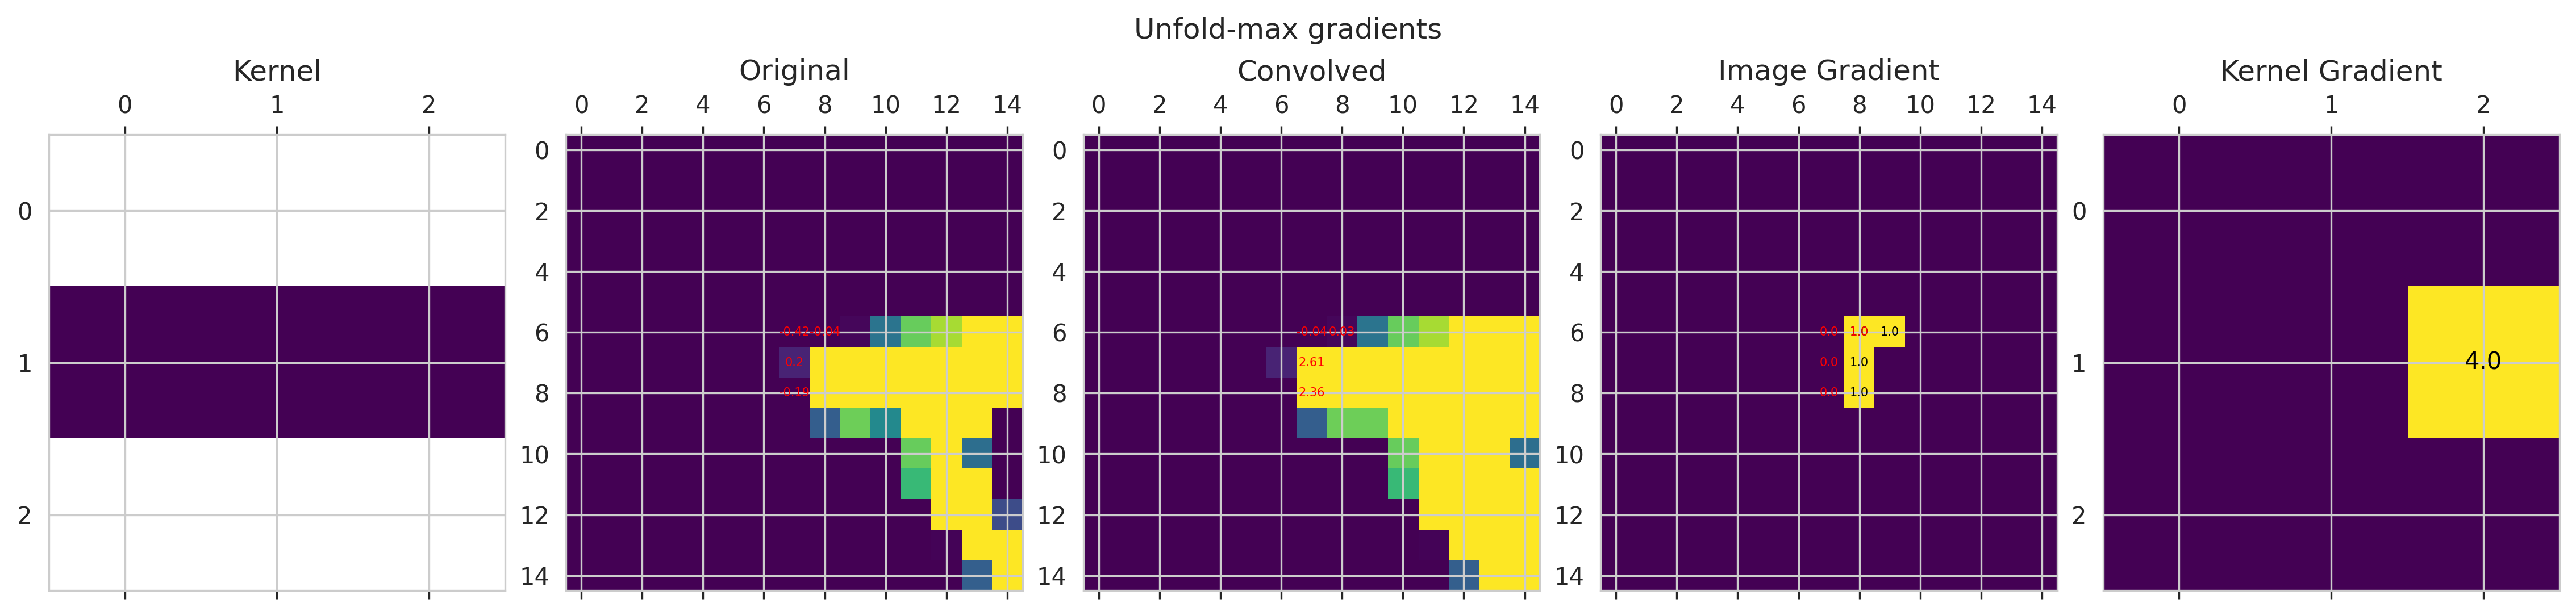

In [34]:
channel_nr = 2
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
# g_imgs[0, channel_nr, 7, 7] *= 100

x_slice = slice(None, 15)
y_slice = slice(None, 15)
target_xs = [7, 7, 7, 8]
target_ys = [6, 7, 8, 6]
target_x = target_y = None
res_imgs, test_provs = max_op(g_imgs, g_kernels)
test_tangent = torch.zeros_like(res_imgs)
test_tangent[0, channel_nr, target_ys, target_xs] = 1
test_i_grad, test_k_grad = max_back_op(g_imgs, g_kernels, test_tangent, test_provs)

_, axs = plt.subplots(ncols=5, layout="compressed", figsize=(15, 15), dpi=300)
axs[0].matshow(g_kernels[channel_nr].numpy(force=True))
axs[0].set_title("Kernel")
axs[1].matshow(
    g_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[1].set_title("Original")
axs[2].matshow(
    res_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[2].set_title("Convolved")
g_np = test_i_grad[0, channel_nr, y_slice, x_slice].numpy(force=True)
axs[3].matshow(g_np)
axs[3].set_title("Image Gradient")
g_np_k = test_k_grad[channel_nr].numpy(force=True)
axs[4].matshow(g_np_k)
axs[4].set_title("Kernel Gradient")
for g_i, g_j in zip(*g_np.nonzero()):
    axs[3].text(
        g_j, g_i, g_np[g_i, g_j], color="black", fontsize=5, ha="center", va="center"
    )
for g_i, g_j in zip(*g_np_k.nonzero()):
    axs[4].text(
        g_j, g_i, g_np_k[g_i, g_j], color="black", fontsize=10, ha="center", va="center"
    )
for ax, ax_arr in zip(axs[1:4], (g_imgs, res_imgs, test_i_grad)):
    for tx, ty in zip(target_xs, target_ys):
        ax.text(
            tx,
            ty,
            ax_arr[0, channel_nr, ty, tx].numpy(force=True).round(2),
            color="red",
            fontsize=5,
            ha="center",
            va="center",
        )
    # ax.scatter(target_x, target_y, marker="x", color='red')
plt.suptitle("Unfold-max gradients")
print("Nonzero gradient in image:", g_np.nonzero())

In [35]:
test_tangent.nonzero().numpy(force=True)

array([[0, 2, 6, 7],
       [0, 2, 6, 8],
       [0, 2, 7, 7],
       [0, 2, 8, 7]])

In [36]:
test_tangent_dense = torch.randn_like(test_imgs)

In [95]:
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
g_imgs.requires_grad_(True)
g_kernels.requires_grad_(True)


def run_one():
    torch.cuda.synchronize()
    arr = unfold_max(g_imgs, g_kernels.unsqueeze(1), padding=1)
    arr.backward(test_tangent_dense)
    del arr
    torch.cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()

15 ms ± 1.93 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [94]:
# @torch.compile
def run_one():
    cuda.synchronize()
    arr, provs = max_op(test_imgs, test_kernels)
    i_grad, k_grad = max_back_op(test_imgs, test_kernels, test_tangent_dense, provs)
    del arr, i_grad, k_grad
    cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()

5.25 ms ± 957 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
plt.set_cmap("viridis")

<Figure size 640x480 with 0 Axes>

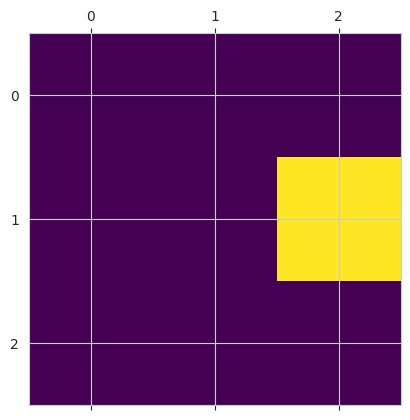

In [40]:
@torch.library.custom_op("semifields::dilation", mutates_args={}, device_types="cuda")
def lib_max_op(
    img: torch.Tensor,
    kernel: torch.Tensor,
    padding: int = 1,
    stride: int = 1,
    dilation: int = 1,
) -> tuple[torch.Tensor, torch.Tensor]:
    return max_op(img, kernel)


@lib_max_op.register_fake
def _(img: torch.Tensor, kernel, padding: int = 1, stride: int = 1, dilation: int = 1):
    assert img.dtype == torch.float32
    assert kernel.dtype == torch.float32
    assert padding == 1
    assert stride == 1
    assert dilation == 1
    return torch.empty_like(img), img.new_empty(img.shape + (2,), dtype=torch.int16)


def _back_setup(ctx, inputs, output):
    img, kernel, padding, stride, dilation = inputs
    _res, prov = output
    ctx.img = img
    ctx.kernel = kernel
    ctx.prov = prov


@torch.library.custom_op(
    "semifields::dilation_back", mutates_args={}, device_types="cuda"
)
def _lib_back_op(
    img: torch.Tensor, kernel: torch.Tensor, tangent: torch.Tensor, prov: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    grad_img, grad_kernel = max_back_op(img, kernel, tangent, prov)
    return grad_img, grad_kernel


@_lib_back_op.register_fake
def _(img, kernel, _tangent, _prov):
    assert img.dtype == torch.float32
    assert kernel.dtype == torch.float32
    assert _tangent.dtype == torch.float32
    assert _prov.dtype == torch.int16
    return torch.empty_like(img), torch.empty_like(kernel)


def _lib_back(ctx, grad_output, _grad_prov):
    return _lib_back_op(ctx.img, ctx.kernel, grad_output, ctx.prov)


lib_max_op.register_autograd(_lib_back, setup_context=_back_setup)

g_kernels.grad = None
g_kernels.requires_grad_(True)
test_tangent = torch.zeros_like(test_imgs)
test_tangent[0, channel_nr, target_ys, target_xs] = 1
lib_max_op(test_imgs, g_kernels)[0].backward(test_tangent)
# TestMaxOp.apply(test_imgs, g_kernels).backward(test_tangent)
plt.matshow(g_kernels.grad[channel_nr].numpy(force=True))

In [41]:
def numba_max(
    img: torch.Tensor,
    kernel: torch.Tensor,
    padding: int = 1,
    stride: int = 1,
    dilation: int = 1,
):
    if len(kernel.shape) == 4:
        kernel = kernel.unsqueeze(1)
    assert img.shape[1] == kernel.shape[0]
    return lib_max_op(img, kernel, padding, stride, dilation)[0]

In [42]:
test_tangent.nonzero().numpy(force=True)

array([[0, 2, 6, 7],
       [0, 2, 6, 8],
       [0, 2, 7, 7],
       [0, 2, 8, 7]])

In [43]:
m_res, m_prov = max_op(test_imgs, g_kernels)
print("no-compile:", m_res.view(-1)[-1].numpy(force=True))
test_i_grad, test_k_grad = max_back_op(g_imgs, g_kernels, test_tangent, m_prov)
g_kernels.grad = None
g_imgs.grad = None
t_res, t_prov = torch.compile(lib_max_op, fullgraph=True)(g_imgs, g_kernels)
print("compiled:", t_res.view(-1)[-1].numpy(force=True))
torch.testing.assert_close(t_res, m_res)
torch.testing.assert_close(t_prov, m_prov)
t_res.backward(test_tangent)
torch.testing.assert_close(g_kernels.grad, test_k_grad)
torch.testing.assert_close(g_imgs.grad, test_i_grad)

no-compile: -0.42407387
compiled: -0.42407387


Text(0.5, 1.0, 'Max lib op, compiled')

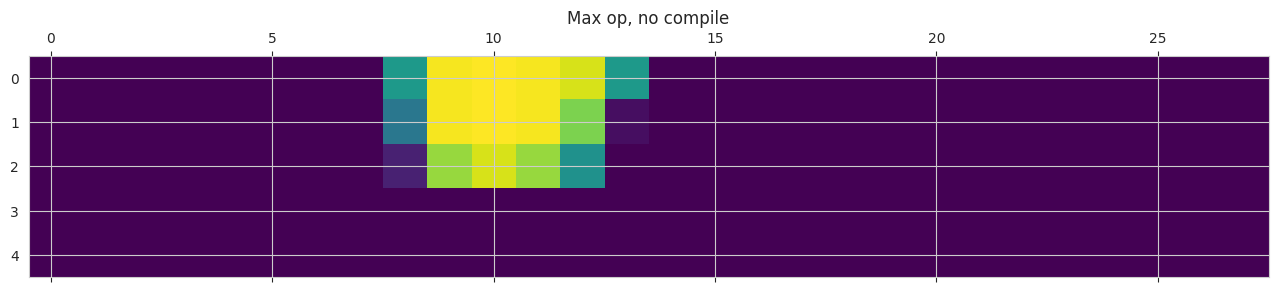

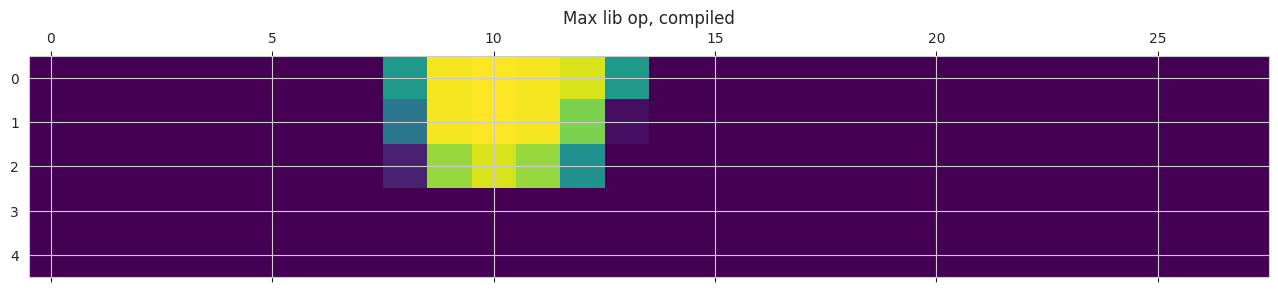

In [44]:
plt.matshow(m_res[2047, 5, 23:].numpy(force=True))
plt.title("Max op, no compile")
plt.matshow(t_res[2047, 5, 23:].numpy(force=True))
plt.title("Max lib op, compiled")

In [45]:
lib_max_op(test_imgs, g_kernels)
torch.library.opcheck(lib_max_op, (test_imgs, g_kernels))

{'test_schema': 'SUCCESS',
 'test_autograd_registration': 'SUCCESS',
 'test_faketensor': 'SUCCESS',
 'test_aot_dispatch_dynamic': 'SUCCESS'}

In [46]:
# the Unfold version doesn't work either, though...
torch.autograd.gradcheck(lib_max_op, (test_imgs[:1], g_kernels), raise_exception=False)

/home/peter/Thesis/.venv/lib/python3.12/site-packages/torch/autograd/gradcheck.py:923: UserWarning: Input #1 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  warnings.warn(
/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 19 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


False

In [47]:
# but I don't override any gradient calculations here, so it must be down to PyTorch messing up the max gradients
torch.autograd.gradcheck(
    convolutions.TropicalConv2D(is_max=True),
    (test_imgs[:1], g_kernels.unsqueeze(1)),
    raise_exception=False,
)

False

In [48]:
@torch.compile(mode="reduce-overhead")
def run_one():
    cuda.synchronize()
    arr, provs = lib_max_op(test_imgs, g_kernels)
    arr.backward(test_tangent_dense)
    del arr
    cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()

In [49]:
from timeit import timeit
from tqdm.auto import tqdm, trange

In [50]:
# fmt: off
slice_sizes = [2, 3, 4, 6, 8, 12, 16, 23, 32, 46, 64, 91, 128, 182, 256, 363, 512, 725, 1024, 1449, 2048]
unfold_timings = [0.00010274730650053243, 8.403245400040759e-05, 8.851143950232653e-05, 0.00010076602150002145,
                  0.00012131676400167635, 0.000124929585501377, 0.00014966875500249443, 0.000199354405496706,
                  0.00025833106350182786, 0.00035760370749994764, 0.0004823765924993495, 0.0006648011590004899,
                  0.0009164136265026173, 0.001269442678501946, 0.0017770433570003662, 0.0025119446479984616,
                  0.0036233893550015636, 0.0052635354004996774, 0.007498402453999006, 0.010653741374000674,
                  0.014994164466501389]
numba_timings = [0.00041991026799951213, 0.0004150625224974647, 0.00041995406449859727, 0.0004226304935000371,
                 0.0004205896764979116, 0.0004200762550026411, 0.00042519056650053245, 0.00043969415899846356,
                 0.000461269485498633, 0.0004921157089993358, 0.0005326687759988999, 0.000598328826999932,
                 0.0006867694915017637, 0.0008550973589990463, 0.0010212399034971896, 0.0012820430794999993,
                 0.0016308881609984381, 0.00213099660050284, 0.002836544132500421, 0.0040347791409985805,
                 0.0056132207165028375]
slice_sizes_detail = [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
unfold_timings_detail = [0.0005231618008999794, 0.0005300874041199859, 0.0005373257529799594, 0.000543491658839921,
                         0.0005501257682598953, 0.0005600170065599377, 0.0005661544485400373, 0.0005724291121000715,
                         0.0005786100002999592, 0.0005850134414200147, 0.0005919706213800236, 0.0005975213742800406,
                         0.0006039276255598815, 0.0006115772961400217, 0.0006184966304400586, 0.000624261617519951,
                         0.0006320271702000172, 0.0006411902578199806, 0.0006466227984400757, 0.0006526624815800461]
numba_timings_detail = [0.0005487732924800366, 0.0005504305595999176, 0.0005602229583999724, 0.0005519845550401078,
                        0.0005552577408599609, 0.0005599274011599482, 0.0005594913014999475, 0.000562018028760067,
                        0.0005715560740999354, 0.000603191901879909, 0.0005728149966799538, 0.0006106505254599324,
                        0.0005787932900199667, 0.0005814040630200179, 0.0005867868537201139, 0.0005937331920399446,
                        0.0006245092738600214, 0.0005905518150200078, 0.000597254317360057, 0.0005953584205200604]
# fmt: on

In [51]:
run_timings = False

In [52]:
if run_timings:
    torch_code = """
    sync()
    arr = dilate(imgs, kernels, padding=1)
    arr.backward(tangent)
    del arr
    sync()
    """
    slice_sizes = []
    unfold_timings = []
    numba_timings = []
    num_loops = 2_000
    bar = trange(2, 23)
    for size_pow in bar:
        test_size = math.ceil(2 ** (size_pow / 2))
        test_slice = test_imgs[:test_size]
        slice_sizes.append(len(test_slice))
        unfold_timings.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": torch.cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.unsqueeze(1).clone().requires_grad_(True),
                    "tangent": torch.randn_like(test_slice),
                    "dilate": unfold_max,
                },
            )
            / num_loops
        )
        numba_timings.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.clone().requires_grad_(True),
                    "tangent": torch.randn_like(test_slice),
                    "dilate": numba_max,
                },
            )
            / num_loops
        )
        bar.set_postfix(
            size=slice_sizes[-1],
            faster="unfold" if unfold_timings[-1] < numba_timings[-1] else "numba",
        )

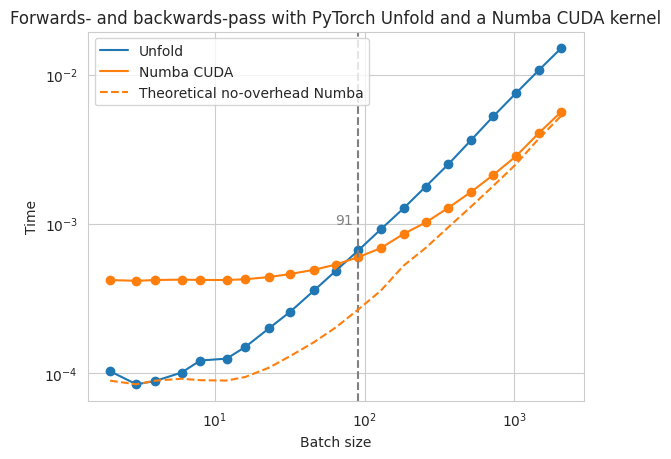

In [53]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.plot(slice_sizes, unfold_timings, label="Unfold", color=colors[0])
plt.scatter(slice_sizes, unfold_timings, color=colors[0])
plt.plot(slice_sizes, numba_timings, label="Numba CUDA", color=colors[1])
plt.scatter(slice_sizes, numba_timings, color=colors[1])
first_better = (np.subtract(unfold_timings, numba_timings) > 0).argmax()
plt.axvline(slice_sizes[first_better], linestyle="dashed", color="grey")
plt.text(slice_sizes[first_better - 1], 10**-3, slice_sizes[first_better], color="grey")
adjusted_numba = np.asarray(numba_timings) - numba_timings[1] + unfold_timings[1]
plt.plot(
    slice_sizes,
    adjusted_numba,
    label="Theoretical no-overhead Numba",
    linestyle="dashed",
    color=colors[1],
)
plt.xlabel("Batch size")
plt.ylabel("Time")
plt.title("Forwards- and backwards-pass with PyTorch Unfold and a Numba CUDA kernel")
plt.loglog()
plt.legend()
plt.show()

In [54]:
if run_timings:
    torch_code = """
    sync()
    arr = dilate(imgs, kernels, padding=1)
    arr.backward(tangent)
    del arr
    sync()
    """
    slice_sizes_detail = []
    unfold_timings_detail = []
    numba_timings_detail = []
    num_loops = 50_000
    bar = trange(70, 90)
    test_tangent = torch.randn_like(test_imgs)
    for test_size in bar:
        test_slice = test_imgs[:test_size]
        slice_sizes_detail.append(len(test_slice))
        unfold_timings_detail.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": torch.cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.unsqueeze(1).clone().requires_grad_(True),
                    "tangent": test_tangent[:test_size],
                    "dilate": unfold_max,
                },
            )
            / num_loops
        )
        numba_timings_detail.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.clone().requires_grad_(True),
                    "tangent": test_tangent[:test_size],
                    "dilate": numba_max,
                },
            )
            / num_loops
        )
        bar.set_postfix(
            size=slice_sizes_detail[-1],
            faster="unfold"
            if unfold_timings_detail[-1] < numba_timings_detail[-1]
            else "numba",
        )

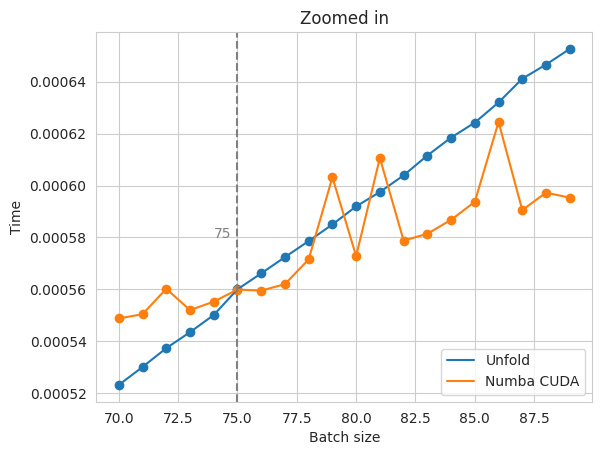

In [55]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.plot(slice_sizes_detail, unfold_timings_detail, label="Unfold", color=colors[0])
plt.scatter(slice_sizes_detail, unfold_timings_detail, color=colors[0])
plt.plot(slice_sizes_detail, numba_timings_detail, label="Numba CUDA", color=colors[1])
plt.scatter(slice_sizes_detail, numba_timings_detail, color=colors[1])
first_better = (np.subtract(unfold_timings_detail, numba_timings_detail) > 0).argmax()
plt.axvline(slice_sizes_detail[first_better], linestyle="dashed", color="grey")
plt.text(
    slice_sizes_detail[first_better - 1],
    0.00058,
    slice_sizes_detail[first_better],
    color="grey",
)
adjusted_numba = (
    np.asarray(numba_timings_detail)
    - numba_timings_detail[1]
    + unfold_timings_detail[1]
)
plt.xlabel("Batch size")
plt.ylabel("Time")
plt.title("Zoomed in")
plt.legend()
plt.show()

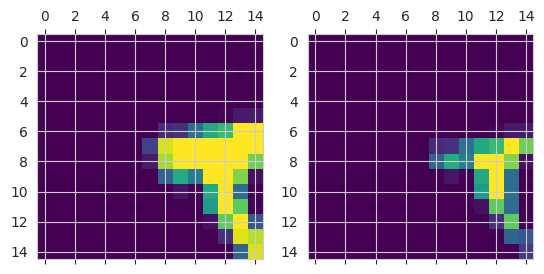

In [116]:
def compile_tropical_op(
    example_imgs: torch.Tensor,
    example_kernels: torch.Tensor,
    *,
    is_max: bool,
    block_size: int = 256,
    kernel_broadcasting: bool = False,
    debug: bool = False,
):
    # === Shape inference & setup
    assert torch.cuda.is_available(), "No CUDA?"
    assert example_imgs.dtype == torch.float32, f"{example_imgs.dtype=}"
    assert example_kernels.dtype == torch.float32, f"{example_kernels.dtype=}"
    assert len(example_imgs.shape) == 4
    i_cs, i_ys, i_xs = example_imgs.shape[1:]
    assert i_ys < np.iinfo(np.int16).max, (
        f"Provenance indices are represented as i16, but {i_ys=}"
    )
    assert i_xs < np.iinfo(np.int16).max, (
        f"Provenance indices are represented as i16, but {i_xs=}"
    )

    if len(example_kernels.shape) == 4:
        example_kernels = example_kernels.squeeze(1)
    k_cs, k_ys, k_xs = example_kernels.shape
    if kernel_broadcasting:
        assert k_cs == 1, f"Asked for kernel broadcasting, but {example_kernels.shape=}"
    else:
        assert i_cs == k_cs, f"No kernel broadcasting, but {i_cs=} != {k_cs=}"

    def one(_v, _w):
        return 1

    def minus_one(_v, _w):
        return -1

    if is_max:
        d_weigh_d_v = d_weigh_d_w = one
    else:
        d_weigh_d_v = one
        d_weigh_d_w = minus_one

    d_weigh_d_v = cuda.jit(d_weigh_d_v, device=True)
    d_weigh_d_w = cuda.jit(d_weigh_d_w, device=True)

    ex_img_shape_no_b = tuple(example_imgs.shape[1:])
    ex_kernel_shape = tuple(example_kernels.shape)
    del example_imgs, example_kernels

    # === Forwards ===
    @cuda.jit(
        "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X
        " float32[:, :, :, :],"  # out_img: [Batch, Channel, Img_Y, Img_X]
        " int16[:, :, :, :, :])",  # out_prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
        debug=debug,
        opt=not debug,
    )
    def conv_cuda_jit(img, kernel, out_img, out_prov):
        idx = cuda.grid(1)
        if idx >= img.size:
            return
        rem, centre_x = divmod(idx, i_xs)
        rem, centre_y = divmod(rem, i_ys)
        b, c = divmod(rem, i_cs)

        top_y, left_x = centre_y - k_ys // 2, centre_x - k_xs // 2
        prov_x = prov_y = -99
        selected_val = -INF if is_max else INF

        for k_y, i_y in enumerate(range(top_y, top_y + k_ys)):
            for k_x, i_x in enumerate(range(left_x, left_x + k_xs)):
                if i_x < 0 or i_x >= i_xs or i_y < 0 or i_y >= i_ys:
                    continue

                img_val = img[b, c, i_y, i_x]
                kernel_val = kernel[0 if kernel_broadcasting else c, k_y, k_x]

                if is_max:
                    val = img_val + kernel_val
                    if val > selected_val:
                        selected_val = val
                        prov_y, prov_x = i_y, i_x
                else:
                    val = img_val - kernel_val
                    if val < selected_val:
                        selected_val = val
                        prov_y, prov_x = i_y, i_x

        out_img[b, c, centre_y, centre_x] = selected_val
        out_prov[b, c, centre_y, centre_x, 0] = prov_y
        out_prov[b, c, centre_y, centre_x, 1] = prov_x

    @torch.library.custom_op(
        "semifields::tropical_op", mutates_args={}, device_types="cuda"
    )
    def conv_cuda_lib(
        img: torch.Tensor, kernel: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        img, kernel = img.detach(), kernel.detach()
        assert kernel.shape == ex_kernel_shape, f"Different {kernel.shape=}"
        assert img.shape[1:] == ex_img_shape_no_b, f"Different {img.shape[1:]=}"
        if debug:
            print("Warning: running CUDA kernel in debug mode")
        out_img = torch.empty_like(img)
        out_prov = torch.empty(img.shape + (2,), device="cuda", dtype=torch.int16)
        n_blocks = math.ceil(img.nelement() / block_size)
        conv_cuda_jit[n_blocks, block_size](img, kernel, out_img, out_prov)
        return out_img, out_prov

    @conv_cuda_lib.register_fake
    def _(img, kernel):
        return torch.empty_like(img), kernel.new_empty(
            img.shape + (2,), dtype=torch.int16
        )

    @torch.compile(fullgraph=True, backend="inductor")
    def conv(
        img: torch.Tensor,
        kernel: torch.Tensor,
        padding: int = 1,
        stride: int = 1,
        dilation: int = 1,
    ):
        if len(kernel.shape) == 4:
            kernel = kernel.squeeze(1)

        if not (padding == stride == dilation == 1):
            raise ValueError

        out_img, _out_prov = conv_cuda_lib(img, kernel)
        return out_img

    # === Backwards ===
    # noinspection PyArgumentList
    @cuda.jit(
        "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X]
        " float32[:, :, :, :],"  # tangent: [Batch, Channel, Img_Y, Img_X]
        " int16[:, :, :, :, :],"  # prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
        " float32[:, :, :, :],"  # out_img_grad: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :])",  # out_kernel_grad: [Channel, Kernel_Y, Kernel_X]
        debug=debug,
        opt=not debug,
    )
    def conv_backwards_cuda_jit(
        img, kernel, tangent, prov, out_img_grad, out_kernel_grad
    ):
        idx = cuda.grid(1)
        if idx >= img.size:
            return
        idx_y, centre_x = divmod(idx, i_xs)
        idx_z, centre_y = divmod(idx_y, i_ys)
        b, c = divmod(idx_z, i_cs)
        tangent = tangent[b, c, centre_y, centre_x]
        if tangent == 0:
            return

        i_prov_x, i_prov_y = (
            prov[b, c, centre_y, centre_x, 1],
            prov[b, c, centre_y, centre_x, 0],
        )
        img_val = img[b, c, i_prov_y, i_prov_x]

        rel_prov_x, rel_prov_y = i_prov_x - centre_x, i_prov_y - centre_y
        k_prov_x, k_prov_y = rel_prov_x + k_xs // 2, rel_prov_y + k_ys // 2
        kernel_val = kernel[c, k_prov_y, k_prov_x]

        dv = d_weigh_d_v(img_val, kernel_val) * tangent
        dw = d_weigh_d_w(img_val, kernel_val) * tangent

        cuda.atomic.add(out_img_grad, (b, c, i_prov_y, i_prov_x), dv)
        cuda.atomic.add(out_kernel_grad, (c, k_prov_y, k_prov_x), dw)

    @torch.library.custom_op(
        "semifields::tropical_op_back", mutates_args={}, device_types="cuda"
    )
    def conv_backwards_cuda_lib(
        img: torch.Tensor,
        kernel: torch.Tensor,
        tangent: torch.Tensor,
        prov: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        img, kernel = img.detach(), kernel.detach()
        n_blocks = math.ceil(tangent.nelement() / block_size)
        out_img_grad = torch.zeros_like(img)
        out_kernel_grad = torch.zeros_like(kernel)
        conv_backwards_cuda_jit[n_blocks, block_size](
            img, kernel, tangent, prov, out_img_grad, out_kernel_grad
        )
        return out_img_grad, out_kernel_grad

    @conv_backwards_cuda_lib.register_fake
    def _(img, kernel, _tangent, _prov):
        return torch.empty_like(img), torch.empty_like(kernel)

    def back_setup(ctx, inputs, output):
        img, kernel = inputs
        _out_img, prov = output
        ctx.img = img
        ctx.kernel = kernel
        ctx.prov = prov

    def lib_back(ctx, grad_output, _grad_prov):
        return conv_backwards_cuda_lib(ctx.img, ctx.kernel, grad_output, ctx.prov)

    conv_cuda_lib.register_autograd(lib_back, setup_context=back_setup)

    return conv


torch.cuda.empty_cache()
ex_op = compile_tropical_op(g_imgs, g_kernels, is_max=False, debug=False)
ex_res = ex_op(g_imgs, g_kernels)

_, axs = plt.subplots(ncols=2)
axs[0].matshow(test_imgs[0, 1, :15, :15].numpy(force=True))
axs[1].matshow(ex_res[0, 1, :15, :15].numpy(force=True));

Nonzero gradient in image: (array([5, 6, 8]), array([8, 7, 6]))


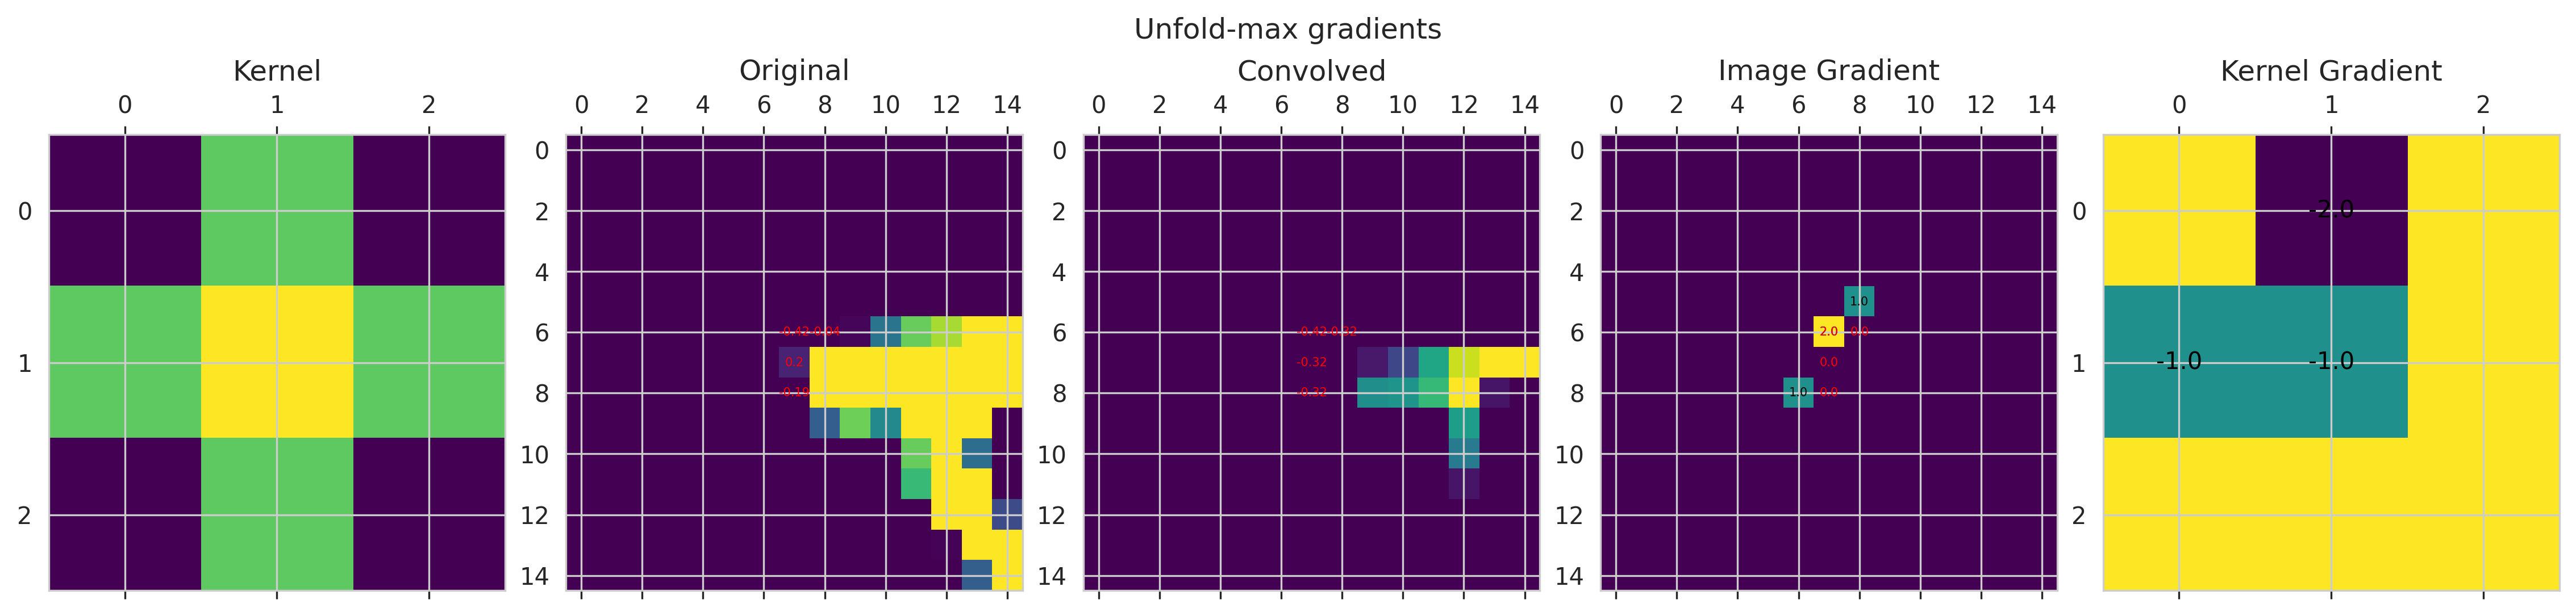

In [117]:
channel_nr = 4
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
# g_imgs[0, channel_nr, 7, 7] *= 100
g_imgs.requires_grad_(True)
g_kernels.requires_grad_(True)
g_imgs.grad = None
g_kernels.grad = None

x_slice = slice(None, 15)
y_slice = slice(None, 15)
target_xs = [7, 7, 7, 8]
target_ys = [6, 7, 8, 6]
target_x = target_y = None
res_imgs = ex_op(g_imgs, g_kernels.unsqueeze(1), padding=1)
res_imgs[0, channel_nr, target_ys, target_xs].sum().backward()
_, axs = plt.subplots(ncols=5, layout="compressed", figsize=(15, 15), dpi=300)
axs[0].matshow(g_kernels[channel_nr].numpy(force=True))
axs[0].set_title("Kernel")
axs[1].matshow(
    g_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[1].set_title("Original")
axs[2].matshow(
    res_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[2].set_title("Convolved")
g_np = g_imgs.grad[0, channel_nr, y_slice, x_slice].numpy(force=True)
axs[3].matshow(g_np)
axs[3].set_title("Image Gradient")
g_np_k = g_kernels.grad[channel_nr].numpy(force=True)
axs[4].matshow(g_np_k)
axs[4].set_title("Kernel Gradient")
for g_i, g_j in zip(*g_np.nonzero()):
    axs[3].text(
        g_j, g_i, g_np[g_i, g_j], color="black", fontsize=5, ha="center", va="center"
    )
for g_i, g_j in zip(*g_np_k.nonzero()):
    axs[4].text(
        g_j, g_i, g_np_k[g_i, g_j], color="black", fontsize=10, ha="center", va="center"
    )
for ax, ax_arr in zip(axs[1:4], (g_imgs, res_imgs, g_imgs.grad)):
    for tx, ty in zip(target_xs, target_ys):
        ax.text(
            tx,
            ty,
            ax_arr[0, channel_nr, ty, tx].numpy(force=True).round(2),
            color="red",
            fontsize=5,
            ha="center",
            va="center",
        )
    # ax.scatter(target_x, target_y, marker="x", color='red')
plt.suptitle("Unfold-max gradients")
print("Nonzero gradient in image:", g_np.nonzero())

In [108]:
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
g_imgs.requires_grad_(True)
g_kernels.requires_grad_(True)


def run_one():
    torch.cuda.synchronize()
    arr = ex_op(g_imgs, g_kernels.unsqueeze(1), padding=1)
    arr.backward(test_tangent_dense)
    del arr
    torch.cuda.synchronize()


torch.cuda.empty_cache()
run_one()
%timeit run_one()
torch.cuda.empty_cache()

5.84 ms ± 3.56 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


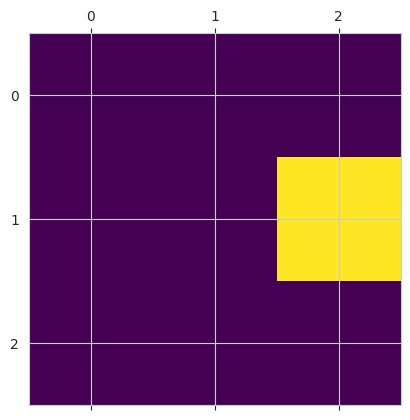

In [240]:
# Alternate form: (can't be traced!)


class TestMaxOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, img: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
        res, prov = max_op(img, kernel)
        ctx.save_for_backward(img, kernel, prov)
        return res

    # noinspection PyMethodOverriding
    @staticmethod
    def backward(ctx, grad_output: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        img, kernel, prov = ctx.saved_tensors
        return max_back_op(img, kernel, grad_output, prov)


g_kernels.grad = None
g_kernels.requires_grad_(True)
TestMaxOp.apply(test_imgs, g_kernels).backward(test_tangent)
plt.matshow(g_kernels.grad[channel_nr].numpy(force=True))